# Penerapan Fuzzy C-Means pada Ketertarikan Musik Indonesia melalui Tangga Nada

> *Notebook ini berisi implementasi Fuzzy C-Means clustering untuk menganalisis pola ketertarikan pendengar terhadap musik Indonesia berdasarkan tangga nada.*  


Dataset shape: (50, 23)

First 5 rows:
                              Track URI             Track Name  \
0  spotify:track:4e6TmHCC4PRUj75knNplNP                  Mangu   
1  spotify:track:2OxvanM5m1Na9OVlXyXmUp            Lesung Pipi   
2  spotify:track:1UPB5rYJ0bzn6mNSoAHrZC  You'll Be in My Heart   
3  spotify:track:654ZF6YNWjQS2NhwR3QnX7                 Komang   
4  spotify:track:0daEJMXc3b4ZMTnvtHpuTt                   Nina   

                  Album Name           Artist Name(s) Release Date  \
0                      Nalar  Fourtwnty,Charita Utami   2023-04-18   
1                Lesung Pipi               Raim Laode   2023-08-31   
2      You'll Be In My Heart                     NIKI   2022-09-14   
3                     Komang               Raim Laode   2022-08-16   
4  Membangun & Menghancurkan                   .Feast   2024-08-30   

   Duration (ms)  Popularity  Added By              Added At  \
0         261048          80       NaN  2025-05-09T13:15:36Z   
1         22515

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Adjusted Rand Index: 0.011
Silhouette Score: 0.424

=== Data Analysis ===
Checking if Major and Minor modes are naturally separable...
Distance between Major and Minor centroids: 0.338
Major mode variance: 0.132
Minor mode variance: 0.166
Separability ratio: 1.132


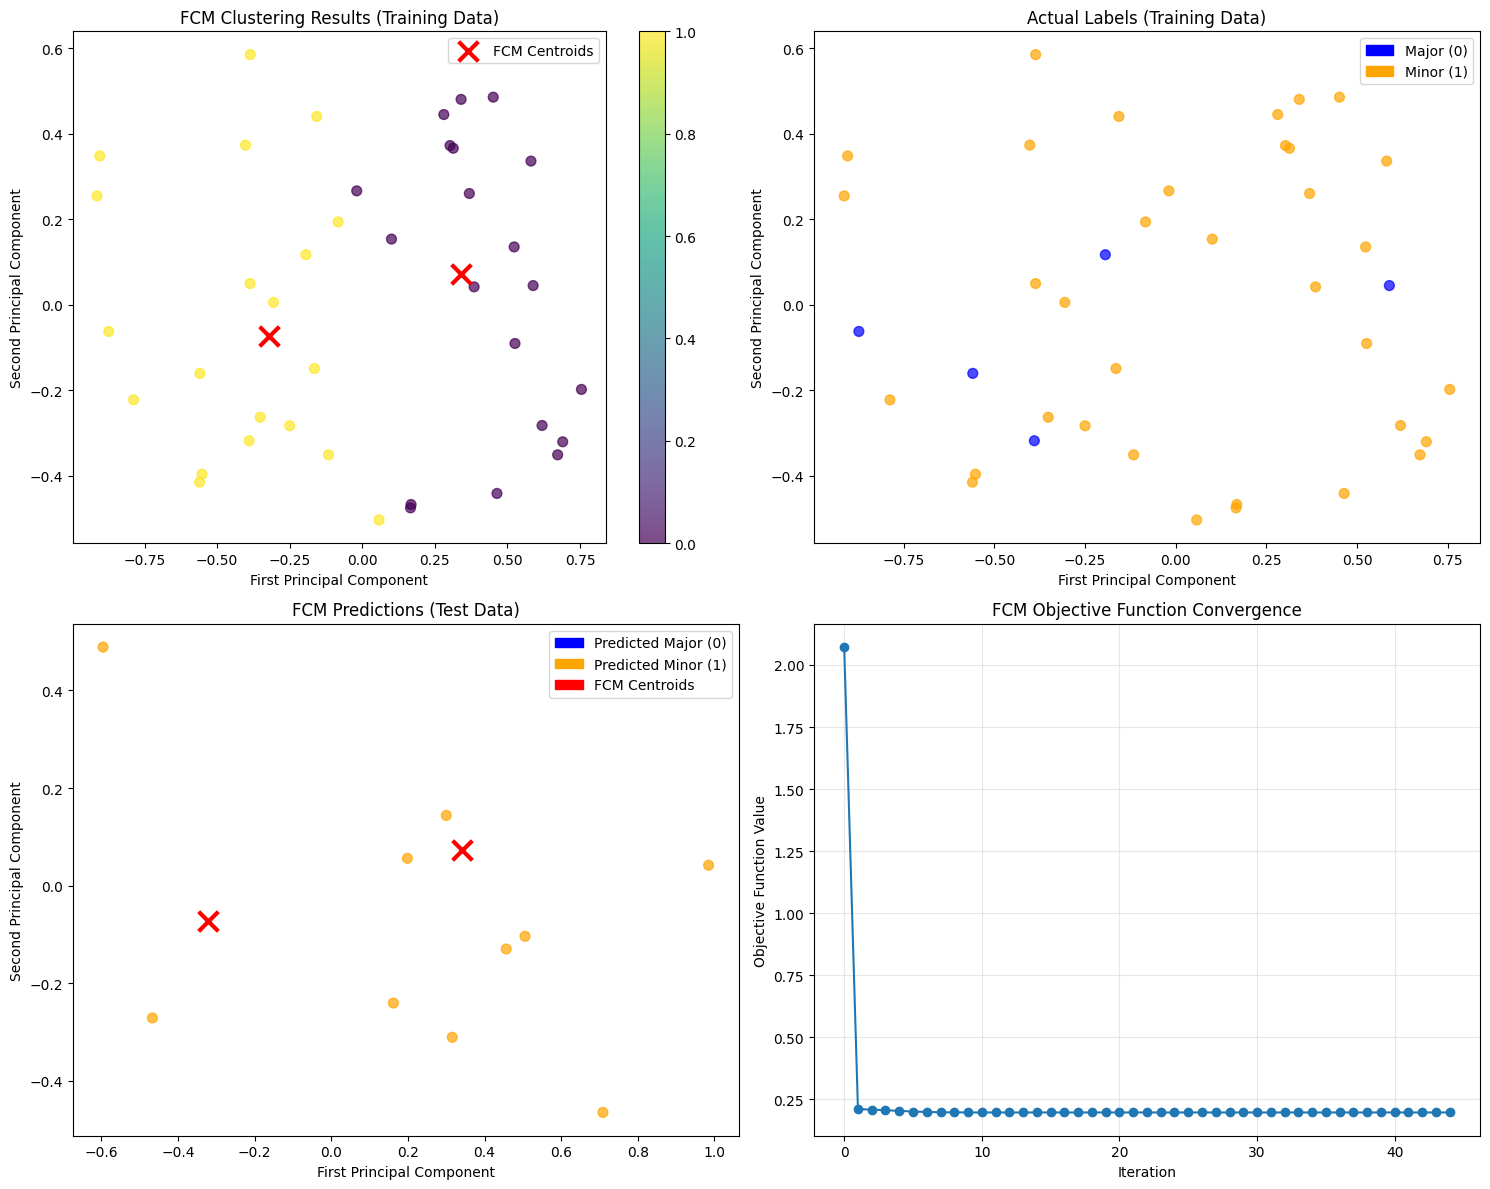


=== Membership Analysis ===
Average membership probabilities for test data:
Cluster 0 (Minor): 0.551
Cluster 1 (Minor): 0.449

Samples with high uncertainty (membership ∈ [0.4, 0.6]):
Sample 1: Memberships = [0.544, 0.456], Actual = 1, Predicted = 1
Sample 3: Memberships = [0.529, 0.471], Actual = 1, Predicted = 1
Sample 4: Memberships = [0.599, 0.401], Actual = 1, Predicted = 1
Sample 5: Memberships = [0.559, 0.441], Actual = 1, Predicted = 1
Sample 6: Memberships = [0.547, 0.453], Actual = 1, Predicted = 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import mode
import seaborn as sns

# Load and clean data
dat_Musik = pd.read_csv('https://raw.githubusercontent.com/ragahammam/machine_learning_projects/refs/heads/main/datasets/top_50_-_indonesia.csv')
print("Dataset shape:", dat_Musik.shape)
print("\nFirst 5 rows:")
print(dat_Musik.head())

# Data cleaning - remove unnecessary columns
Clean_Musik = dat_Musik.drop(dat_Musik.columns[0:11], axis=1)
Clean_Musik = Clean_Musik.drop(columns=['Time Signature'])
print("\nCleaned dataset shape:", Clean_Musik.shape)
print("\nCleaned dataset columns:", Clean_Musik.columns.tolist())

# Separate features and target
x = Clean_Musik.drop(columns=['Mode'])
y = Clean_Musik['Mode']

print("\nFeatures shape:", x.shape)
print("Target distribution:")
print(y.value_counts())

# Check if we have both classes
if len(y.unique()) < 2:
    print("WARNING: Dataset only contains one class!")
    print("Unique values in target:", y.unique())

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train set target distribution:")
print(y_train.value_counts())
print(f"Test set target distribution:")
print(y_test.value_counts())

# Normalization
scaler = MinMaxScaler()
X_normalized_train = scaler.fit_transform(X_train)
X_normalized_test = scaler.transform(X_test)

# PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_normalized_train)
X_pca_test = pca.transform(X_normalized_test)

print(f"\nExplained variance ratio by PCA components: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

# Improved Fuzzy C-Means implementation
class FuzzyCMeans:
    def __init__(self, n_clusters, m=7, max_iter=100, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.m = m  # Fuzziness parameter
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Initialize membership matrix with random values and normalize
        self.U = np.random.rand(n_samples, self.n_clusters)
        self.U = self.U / np.sum(self.U, axis=1, keepdims=True)
        self.centroids = np.zeros((self.n_clusters, n_features))

        self.history = {'centroids': [], 'objective': []}

        for iteration in range(self.max_iter):
            # Update centroids
            for i in range(self.n_clusters):
                numerator = np.sum((self.U[:, i] ** self.m).reshape(-1, 1) * X, axis=0)
                denominator = np.sum(self.U[:, i] ** self.m)
                self.centroids[i] = numerator / denominator

            # Calculate objective function
            objective = self._calculate_objective(X)
            self.history['objective'].append(objective)
            self.history['centroids'].append(self.centroids.copy())

            # Calculate distances between samples and centroids
            distances = pairwise_distances(X, self.centroids)
            # Avoid division by zero
            distances = np.fmax(distances, np.finfo(np.float64).eps)

            self.U_old = self.U.copy()

            # Update membership matrix
            for i in range(n_samples):
                for j in range(self.n_clusters):
                    denominator = 0
                    for k in range(self.n_clusters):
                        denominator += (distances[i, j] / distances[i, k]) ** (2 / (self.m - 1))
                    self.U[i, j] = 1 / denominator

            # Check convergence
            if np.linalg.norm(self.U - self.U_old) < self.tol:
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iter})")

        return self

    def _calculate_objective(self, X):
        """Calculate the objective function value"""
        distances = pairwise_distances(X, self.centroids)
        objective = np.sum(self.U ** self.m * distances ** 2)
        return objective

    def predict(self, X):
        """Predict cluster labels for new data"""
        distances = pairwise_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def predict_proba(self, X):
        """Predict membership probabilities for new data"""
        distances = pairwise_distances(X, self.centroids)
        distances = np.fmax(distances, np.finfo(np.float64).eps)

        n_samples = X.shape[0]
        U_new = np.zeros((n_samples, self.n_clusters))

        for i in range(n_samples):
            for j in range(self.n_clusters):
                denominator = 0
                for k in range(self.n_clusters):
                    denominator += (distances[i, j] / distances[i, k]) ** (2 / (self.m - 1))
                U_new[i, j] = 1 / denominator

        return U_new

# Apply Fuzzy C-Means
print("\n=== Applying Fuzzy C-Means ===")
fcm = FuzzyCMeans(n_clusters=2, m=7, max_iter=1000, tol=1e-6, random_state=42)
fcm.fit(X_pca_train)

# Make predictions
train_predictions = fcm.predict(X_pca_train)
test_predictions = fcm.predict(X_pca_test)

# Get membership probabilities
train_proba = fcm.predict_proba(X_pca_train)
test_proba = fcm.predict_proba(X_pca_test)

print(f"\nCentroids:")
for i, centroid in enumerate(fcm.centroids):
    print(f"Cluster {i}: [{centroid[0]:.3f}, {centroid[1]:.3f}]")

# Analyze cluster distribution
print(f"\nTraining set cluster distribution:")
unique, counts = np.unique(train_predictions, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} samples ({count/len(train_predictions)*100:.1f}%)")

# IMPROVED: Better cluster-to-label mapping using confusion matrix approach
def find_best_cluster_mapping(predictions, true_labels, n_clusters):
    """
    Find the best mapping from clusters to labels using Hungarian algorithm approach
    """
    from sklearn.metrics import confusion_matrix

    # Create confusion matrix between clusters and true labels
    cm = confusion_matrix(true_labels, predictions)
    print(f"\nCluster-Label Confusion Matrix:")
    print("Rows: True labels (0=Major, 1=Minor)")
    print("Cols: Predicted clusters")
    print(cm)

    # Find best mapping by maximizing diagonal
    mapping = {}
    available_labels = list(range(len(np.unique(true_labels))))

    for cluster in range(n_clusters):
        # Find which label has highest count for this cluster
        cluster_mask = (predictions == cluster)
        if np.any(cluster_mask):
            cluster_true_labels = true_labels[cluster_mask]
            # Count occurrences of each label in this cluster
            label_counts = {}
            for label in available_labels:
                label_counts[label] = np.sum(cluster_true_labels == label)

            # Assign the most frequent label to this cluster
            best_label = max(label_counts.items(), key=lambda x: x[1])[0]
            mapping[cluster] = best_label

            print(f"Cluster {cluster}:")
            for label, count in label_counts.items():
                mode_name = 'Minor' if label == 1 else 'Major'
                percentage = count / len(cluster_true_labels) * 100
                print(f"  {mode_name} (label {label}): {count} samples ({percentage:.1f}%)")

            mode_name = 'Minor' if best_label == 1 else 'Major'
            print(f"  -> Mapped to: {mode_name} (label {best_label})")
        else:
            mapping[cluster] = 0  # Default mapping

    return mapping

# Apply improved mapping
label_map = find_best_cluster_mapping(train_predictions, y_train.values, fcm.n_clusters)

# Apply mapping to get final predictions
mapped_train_predictions = np.array([label_map[cluster] for cluster in train_predictions])
mapped_test_predictions = np.array([label_map[cluster] for cluster in test_predictions])

# Calculate accuracy
train_accuracy = accuracy_score(y_train, mapped_train_predictions)
test_accuracy = accuracy_score(y_test, mapped_test_predictions)

print(f"\n=== Performance Metrics ===")
print(f"Training Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"Testing Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

print(f"\nClassification Report (Test Set):")
print(classification_report(y_test, mapped_test_predictions,
                          target_names=['Major', 'Minor']))

print(f"\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, mapped_test_predictions)
print("Rows: Actual labels")
print("Cols: Predicted labels")
print(cm)

# Additional analysis - check if clustering is actually separating the classes
print(f"\n=== Cluster Quality Analysis ===")
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Calculate clustering quality metrics
ari_score = adjusted_rand_score(y_train, train_predictions)
silhouette_avg = silhouette_score(X_pca_train, train_predictions)

print(f"Adjusted Rand Index: {ari_score:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Check class separability in the data
print(f"\n=== Data Analysis ===")
print("Checking if Major and Minor modes are naturally separable...")

# Calculate distance between class centroids
major_mask = (y_train == 0)
minor_mask = (y_train == 1)

if np.any(major_mask) and np.any(minor_mask):
    major_centroid = np.mean(X_pca_train[major_mask], axis=0)
    minor_centroid = np.mean(X_pca_train[minor_mask], axis=0)

    centroid_distance = np.linalg.norm(major_centroid - minor_centroid)
    print(f"Distance between Major and Minor centroids: {centroid_distance:.3f}")

    # Calculate within-class variances
    major_var = np.mean(np.var(X_pca_train[major_mask], axis=0))
    minor_var = np.mean(np.var(X_pca_train[minor_mask], axis=0))

    print(f"Major mode variance: {major_var:.3f}")
    print(f"Minor mode variance: {minor_var:.3f}")
    print(f"Separability ratio: {centroid_distance / (major_var + minor_var):.3f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training data with FCM clusters
ax1 = axes[0, 0]
scatter1 = ax1.scatter(X_pca_train[:, 0], X_pca_train[:, 1],
                      c=train_predictions, cmap='viridis', alpha=0.7, s=50)
ax1.scatter(fcm.centroids[:, 0], fcm.centroids[:, 1],
           marker='x', color='red', s=200, linewidth=3, label='FCM Centroids')
ax1.set_title('FCM Clustering Results (Training Data)')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend()
plt.colorbar(scatter1, ax=ax1)

# 2. Training data with actual labels
ax2 = axes[0, 1]
colors = ['blue' if label == 0 else 'orange' for label in y_train]
scatter2 = ax2.scatter(X_pca_train[:, 0], X_pca_train[:, 1],
                      c=colors, alpha=0.7, s=50)
ax2.set_title('Actual Labels (Training Data)')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')

# Add manual legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Major (0)')
orange_patch = mpatches.Patch(color='orange', label='Minor (1)')
ax2.legend(handles=[blue_patch, orange_patch])

# 3. Test data with predictions
ax3 = axes[1, 0]
pred_colors = ['blue' if pred == 0 else 'orange' for pred in mapped_test_predictions]
scatter3 = ax3.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
                      c=pred_colors, alpha=0.7, s=50)
ax3.scatter(fcm.centroids[:, 0], fcm.centroids[:, 1],
           marker='x', color='red', s=200, linewidth=3, label='FCM Centroids')
ax3.set_title('FCM Predictions (Test Data)')
ax3.set_xlabel('First Principal Component')
ax3.set_ylabel('Second Principal Component')
ax3.legend()

# Add manual legend for predictions
blue_patch = mpatches.Patch(color='blue', label='Predicted Major (0)')
orange_patch = mpatches.Patch(color='orange', label='Predicted Minor (1)')
ax3.legend(handles=[blue_patch, orange_patch,
                   mpatches.Patch(color='red', label='FCM Centroids')])

# 4. Objective function convergence
ax4 = axes[1, 1]
ax4.plot(fcm.history['objective'], marker='o')
ax4.set_title('FCM Objective Function Convergence')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Objective Function Value')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze membership probabilities
print(f"\n=== Membership Analysis ===")
print(f"Average membership probabilities for test data:")
for i in range(fcm.n_clusters):
    mode_name = 'Minor' if label_map[i] == 1 else 'Major'
    avg_membership = np.mean(test_proba[:, i])
    print(f"Cluster {i} ({mode_name}): {avg_membership:.3f}")

# Show some examples with high uncertainty (fuzzy membership)
uncertainty_threshold = 0.4  # Both memberships between 0.4-0.6
uncertain_samples = []
for i in range(len(test_proba)):
    if all(prob >= uncertainty_threshold and prob <= (1-uncertainty_threshold)
           for prob in test_proba[i]):
        uncertain_samples.append(i)

if uncertain_samples:
    print(f"\nSamples with high uncertainty (membership ∈ [{uncertainty_threshold}, {1-uncertainty_threshold}]):")
    for idx in uncertain_samples[:5]:  # Show first 5 uncertain samples
        probs = test_proba[idx]
        actual = y_test.iloc[idx]
        predicted = mapped_test_predictions[idx]
        print(f"Sample {idx}: Memberships = [{probs[0]:.3f}, {probs[1]:.3f}], "
              f"Actual = {actual}, Predicted = {predicted}")
else:
    print(f"\nNo samples found with high uncertainty (threshold = {uncertainty_threshold})")
